In [149]:
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from pandas import  *
from numpy import *
from sklearn import *
import warnings
from sklearn.preprocessing import Imputer
warnings.filterwarnings('ignore')
inf552= pd.read_csv("C:\\Users\\DELL\\Desktop\\INF552\\HM6\\data_banknote_authentication.csv",header=None,names=list(range(0,4))+['class'])

In [150]:
#  Choose 472 data points randomly as the test set, and the remaining 900 points as the training set
from sklearn.svm import LinearSVC
test=inf552.sample(n=472,random_state=123 ,axis=0)
train=inf552.drop(index=test.index)
#determine the ranges for λ that keep the accuracy above a threshold (e.g.60%)
cls1 = LinearSVC(penalty='l1',random_state=123,dual=False,C=10**(-3)).fit(train[list(range(0,4))], train['class'])
print('the accuracy for λ = 10−3 is: ',cls1.score(train[list(range(0,4))], train['class']))
cls2 = LinearSVC(penalty='l1',random_state=123,dual=False,C=10**(2)).fit(train[list(range(0,4))], train['class'])
print('the accuracy for λ = 10+2 is: ',cls2.score(train[list(range(0,4))], train['class']))
print('the accuracy will not below 60% for λ = 10−3 and λ = 10+2')

the accuracy for λ = 10−3 is:  0.8977777777777778
the accuracy for λ = 10+2 is:  0.9911111111111112
the accuracy will not below 60% for λ = 10−3 and λ = 10+2


In [153]:
# passive learning
# Train a SVM with a pool of 10 selected data points from the trainset(90 times)
from sklearn.model_selection import GridSearchCV
import sklearn.metrics 
errors=[]
for i in range(50):
    error=[]
    testset=test
    trainset=train
    train_pool=trainset.sample(n=10,axis=0)
    # If all selected data points are from one class, select another set of 10 data points randomly.
    while len(train_pool['class'].value_counts())==1:
         train_pool=trainset.sample(n=10,axis=0)
    trainset=trainset.drop(index=train_pool.index)
    # Determine the weight of the SVM penalty 
    C_range1 = np.logspace(-3, 2, 5)
    param_grid1 = dict(C=C_range1)
    passive_cls = LinearSVC(penalty='l1',dual=False)
    passive_model =  GridSearchCV(passive_cls, param_grid=param_grid1, cv=KFold(n_splits=10)).fit(train_pool[list(range(0,4))], train_pool['class'])
    test_pred=passive_model.predict(testset[list(range(0,4))]);
    error.append(1-metrics.accuracy_score(testset['class'], test_pred))
    for i in range(89):
        new_pool=trainset.sample(n=10,axis=0)
        train_pool=train_pool.append(new_pool)
        trainset=trainset.drop(index=new_pool.index)
        C_range1 = np.logspace(-3, 2, 5)
        param_grid1 = dict(C=C_range1)
        passive_cls = LinearSVC(penalty='l1',dual=False)
        passive_model =  GridSearchCV(passive_cls, param_grid=param_grid1, cv=10).fit(train_pool[list(range(0,4))], train_pool['class'])
        test_pred=passive_model.predict(testset[list(range(0,4))]);
        error.append(1-metrics.accuracy_score(testset['class'], test_pred))
    errors.append(error)

In [173]:
# active learning
# Train a SVM with a pool of 10 selected data points from the trainset(90 times)
errors2=[]
for i in range(50):
    error2=[]
    testset2=test
    trainset2=train
    train_pool2=trainset2.sample(n=10,axis=0)
    # If all selected data points are from one class, select another set of 10 data points randomly.
    while len(train_pool2['class'].value_counts())==1:
         train_pool2=trainset2.sample(n=10,axis=0)
    trainset2=trainset2.drop(index=train_pool2.index)
    # Determine the weight of the SVM penalty 
    C_range2 = np.logspace(-3, 2, 5)
    param_grid2 = dict(C=C_range2)
    active_cls = LinearSVC(penalty='l1',dual=False)
    active_model =  GridSearchCV(active_cls, param_grid=param_grid2, cv=KFold(n_splits=10)).fit(train_pool2[list(range(0,4))], train_pool2['class'])
    test_pred2=active_model.predict(testset2[list(range(0,4))]);
    error2.append(1-metrics.accuracy_score(testset2['class'], test_pred2))
    for j in range(89):
        # Choose the 10 closest data points in the training set to the hyperplane of the SVM
        aa=(active_model.decision_function(trainset2[list(range(0,4))])).tolist();
        w_norm = np.linalg.norm(active_model.best_estimator_.coef_);dist=aa/ w_norm;
        ind = np.argsort(dist)[:10];
        new_pool2=trainset2.iloc[ind,:]
        train_pool2=train_pool2.append(new_pool2)
        trainset2=trainset2.drop(index=new_pool2.index)
        C_range2 = np.logspace(-3, 2, 5)
        param_grid2 = dict(C=C_range2)
        active_cls = LinearSVC(penalty='l1',dual=False)
        active_model =  GridSearchCV(active_cls, param_grid=param_grid2, cv=10).fit(train_pool2[list(range(0,4))], train_pool2['class'])
        test_pred2=active_model.predict(testset2[list(range(0,4))]);
        error2.append(1-metrics.accuracy_score(testset2['class'], test_pred2))
    errors2.append(error2)

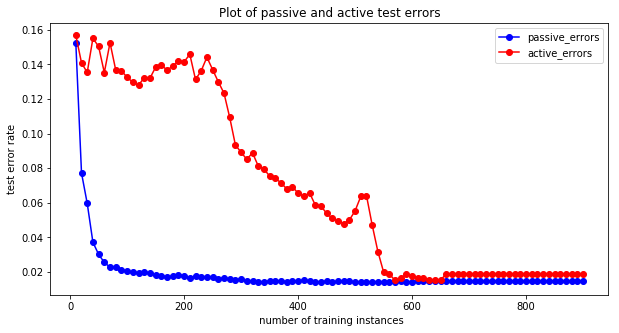

In [174]:
# Plot the average test error versus number of training instances
trans_errors=np.transpose(errors);trans_errors2=np.transpose(errors2);
passive_errors=[];active_errors=[];
for i in range(90):
    passive_errors.append(trans_errors[i].mean());
    active_errors.append(trans_errors2[i].mean());
means={"passive_errors":passive_errors,"active_errors":active_errors}
means=DataFrame(means)
#errors.index = range(10,901,10)
plt.figure(figsize=(10,5))
xlist1 = means.iloc[:,0]
xlist2 = means.iloc[:,1]
ylist = list(range(10,901,10))
plt.title("Plot of passive and active test errors") 
plt.xlabel(" number of training instances")
plt.ylabel("test error rate")
plt.plot(ylist,xlist1,"b-o")
plt.plot(ylist,xlist2,"r-o")
plt.legend(loc='best')
plt.show()

In [1]:
print('the conclusion: when the number of trainning instances is small, the passive learning is better than active one.')
print('when the number of instances is large enough, there is a slightly difference between passive and active learning.')

the conclusion: when the number of trainning instances is small, the passive learning is better than active one.
when the number of instances is large enough, there is a slightly difference between passive and active learning.
